# MiniProyecto 2: Segmentación de higado en volumenes MRI

## Entrega 1: 

En el anterior miniproyecto empezamos a relacionarnos con las tareas de la visión por computador y la metodología de investigación, que va desde la visualización y el entendimiento del problema a resolver, pasando por la planeación de experimentos y el pre-procesamiento, para finalizar con el desarrollo de un algoritmo completo y su metodología de evaluación. En el anterior miniproyecto nos centramos en la detección, una tarea de clasificación binaria donde buscamos remarcar o delimitar un objeto en una ventana. Ahora, nos familiarizaremos con la tarea de segmentación, con la que ya pudimos experimentar en la entrega pasada, pero ahora siendo el problema principal y no un vehiculo para la detección. Debemos recordar que la segmentación es una refinación de la tarea de clasificación, donde queremos asignarle a cada pixel una etiqueta, en este caso será una clasificaicón binaria donde la clase 0 es el fondo y la clase 1 será el higado. 

### Parte 1: Exploración de base de datos

Como aprendimos anteriormente, lo primero que debemos hacer es familiarizarnos con la base de datos. En esta ocasión no tenemos imagenes como tal sino volumenes ya que tratamos con imagenes medicas, en conctreto, MRI.

#### Parte 1.1: Importación de imagenes y anotaciones

Para poder abrir los archivos de MRI debemos usar la libreria **nibabel**. Use las siguientes celdas para cargar todos los volúmenes de la carpeta de entrenamiento de DB. En este caso guardaremos los diferentes volúmenes en diccionarios, donde las llaves de cada volúmenes serán los nombres de árchivo sin la extención. Por ejemplo, para el archivo llamado volume_0.nii, la llave será volume_0.

> - **Nota** Para poder abrir los volumenes debe usar la función *load* y la función *get_fdata*. Puede ver un ejemplo en este link https://nipy.org/nibabel/gettingstarted.html.
> - **Nota** Por ahora trabajaremos con estos volúmenes pero en la próxima entrega introduciremos más volúmenes para realizar una metodología más completa.
> - Si quieren separar los path con el método .split() utilicen el caracter os.sep para obtener el separador del sistema operativo.

In [17]:
try:
    import nibabel as nib
except:
    print("No se encuentra instalada la librería por lo que procederá a instalarse")
    !pip install nibabel
    import nibabel as nib
    
# Librerías por instalar
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import correlate
from scipy.ndimage import minimum_filter, maximum_filter, median_filter

from skimage.measure import label

In [26]:
vols_path= glob(os.path.join('DB/train', '*.nii.gz')) #lista de paths para todos los volúmenes
dict_vols={} #diccionario que contendran los volúmenes

for path in vols_path:
    nombre = os.path.basename(path).replace('.nii.gz','')
    vol = nib.load(path).get_fdata()
    dict_vols[nombre] = vol

In [27]:
print(dict_vols.keys())

dict_keys(['segmentation_0', 'segmentation_1', 'segmentation_10', 'segmentation_11', 'segmentation_12', 'segmentation_13', 'segmentation_14', 'segmentation_15', 'segmentation_18', 'segmentation_19', 'segmentation_2', 'segmentation_20', 'segmentation_21', 'segmentation_23', 'segmentation_27', 'segmentation_28', 'segmentation_29', 'segmentation_5', 'segmentation_6', 'segmentation_9', 'volume_0', 'volume_1', 'volume_10', 'volume_11', 'volume_12', 'volume_13', 'volume_14', 'volume_15', 'volume_18', 'volume_19', 'volume_2', 'volume_20', 'volume_21', 'volume_23', 'volume_27', 'volume_28', 'volume_29', 'volume_5', 'volume_6', 'volume_9'])


In [28]:
assert len(vols_path)==40, f'No extrajo todos los volúmenes deberían ser 40 y tiene {len(vols_path)}'
assert 'volume_6' in dict_vols.keys(), f'No llamó de la forma correcta los archivos'
assert np.isclose(np.sum(dict_vols['volume_11']),-1676872989.6721125,0.01), f'Para el volumen 11 no se extrajo el volumen correcto'

#### Parte 1.2 Distribución de la base de datos
Ya tenemos distribuido nuestro dataset en diccionarios facilmente accesibles vamos a explorar la distribución de los datos. Al igual que en los problemas de detección, tendremos una distribución de etiquetas dentro de cada dato, recuerden que nuestros datos son volumenes. Use la siguiente celda para encontrar la cantidad de pixeles de cada clase en el volumen de segmentación 0. Tambien saque los porcentages de estas clases. Todo el dataset tiene 3 labels y cada label es un numero, tengalo en cuenta.

> **Recomendación:** Use np.unique (busque la documentación) para encontrar los labels de las segmentaciones, sabemos que son numeros pero no que numeros son.

In [272]:
seg_vol = dict_vols['segmentation_0']
labels, counts= np.unique(seg_vol, return_counts=True) #arreglo con las etiquetas del volumen de segmentación

In [ ]:
label_0= counts[labels == 0][0] if 0 in labels else 0 #cantidad de voxeles con la etiqueta 0
label_1= counts[labels == 1][0] if 1 in labels else 0 #cantidad de voxeles con la etiqueta 1
label_2= counts[labels == 2][0] if 2 in labels else 0 #cantidad de voxeles con la etiqueta 2

total = seg_vol.size
percentage_label_0= (label_0 / total) * 100 # Porcentaje de voxeles con la etiqueta 0
percentage_label_1= (label_1 / total) * 100 # Porcentaje de voxeles con la etiqueta 1
percentage_label_2= (label_2 / total) * 100 # Porcentaje de voxeles con la etiqueta 2

In [31]:
print ("{:<15} {:<20}\t\t {:<30}".format('Clase','Total voxeles por clase','Porcentaje de voxeles por clase'))
print ('------------------------------------------------------------------------------------------------')
print ("{:<15} {:<20}\t\t {:.4f} %".format(labels[0],label_0,percentage_label_0))
print ("{:<15} {:<20}\t\t {:.4f} %".format(labels[1],label_1,percentage_label_1))
print ("{:<15} {:<20}\t\t {:.4f} %".format(labels[2],label_2,percentage_label_2))

Clase           Total voxeles por clase		 Porcentaje de voxeles por clase
------------------------------------------------------------------------------------------------
0.0             2355666             		 97.1476 %
1.0             68852               		 2.8395 %
2.0             314                 		 0.0129 %


In [33]:
assert len(labels)==3, 'Estas contando de más o menos las etiquetas dentro del dataset'
assert np.min(labels)==0, 'No estas contando la etiqueta 0'
assert np.max(labels)==2, 'No estas contando la etiqueta 2'
assert np.isclose(label_0+label_1+label_2,2424832,0.01), 'No esta mirando todo el dataset de entrenamiento'
assert np.isclose(label_0,2355666,0.001), f'La cantidad de voxeles de la clase 0 en el volumen de segmentación 0 debería ser 2355666 y es {label_0}'

#### Parte 1.3: Visualización de anotaciones
Veamos ahora los datos con los que vamos a trabajar. Sabemos que nuestros datos originales son MRI, son volumenes, pero aun no sabemos como serán nuestras anotaciones. Esto es importante porque, como todo problema de vision por computador, debemos saber cuales son nuestros inputs y cuales queremos que sean nuestros outputs. En la siguiente celda use el volumen original y busque cual es el slice de la anotación (volumen segmentado) que más area de segmentación tiene en cada eje axial. Haga un plot de del corte y de la segmentacion más grande. 

> **Recuerde:** Tenemos el label del fondo (0) y las demas labels, pero nosotros solo queremos tratar con una segmentación binaria. De ahora en adelante, las labels que son diferentes de 0 serán 1.

32


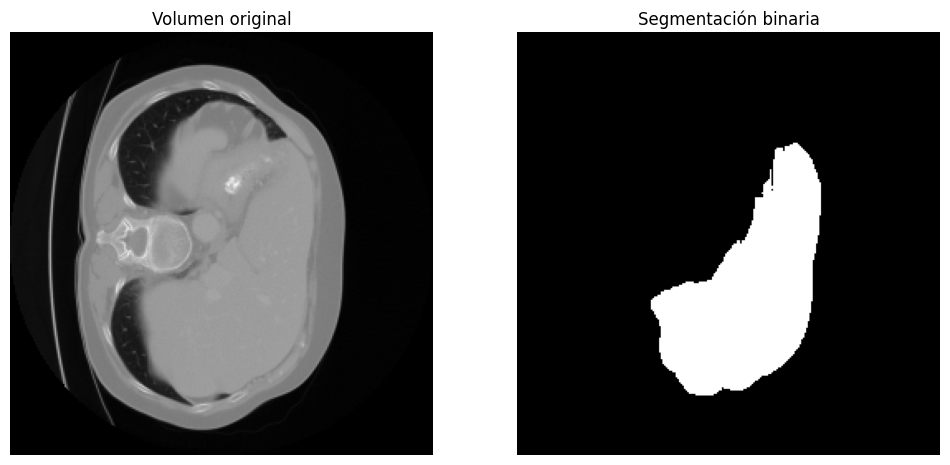

In [40]:
vol = dict_vols["volume_0"]
seg = dict_vols["segmentation_0"]

seg_bin = (seg != 0)

areas = [np.sum(seg_bin[:, :, i]) for i in range(seg_bin.shape[2])]
slice_axial = int(np.argmax(areas))   #Slice con mayor area de higado en el eje axial
area_axial = int(np.max(areas))       #Mayor area de higado en eje axial
print(slice_axial)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(vol[:, :, slice_axial], cmap="gray")
plt.title("Volumen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(seg_bin[:, :, slice_axial], cmap="gray")
plt.title("Segmentación binaria")
plt.axis("off")

plt.show()

In [39]:
assert np.isclose(slice_axial,32,0.01), 'El eje mayor no es el encontrado. El eje axial es la ultima coordenada, la transversal es la segunda y la sagital es la primera'
assert np.isclose(np.sum(dict_vols['segmentation_0'][:,:,slice_axial]>0)-area_axial,0), 'El area del higado guardado en la variable no es igual al slice de maxima area determinada'

### Parte 2: Anotación
El problema que queremos tratar es el de la segmentación del higado. La segmentación que realizaremos se basará directamente en las intensidades de nuestra imagen. Un punto a destacar es la diferencia que tenemos con la anterior base de datos, ahora no contamos con imagenes a color y muchos tejidos tendrán una intensidad similar a la de nuestro organo de interes.

#### Parte 2.1: Histograma
Usted cuenta con volumenes de anotación, si visualizó con cuidado sus anotaciones sabrá que son volumenes de etiquetas (0,1,2 aunque consideramos el 2 y el 1 como una misma etiqueta) Utilice este volumen de anotación para extraer el higado con sus intensidades originales. Posteriormente, realice un plot mostrando el organo y su histograma (no nos importan las intensidades de 0 porque son el fondo). Utilice el volumen 0 y su respectiva segmentación. Debe hacer el histograma para todo el higado, no solo una slice.

> - **Nota:** En este caso trabajamos sobre los volumenes crudos de datos, por lo que la escala de los datos tambien incluye numeros negativos.

> - **Pista:** Si su volumen de segmentación tiene valores de 0 o 1, si se multiplica cualquier valor por 0, este desaparecerá, y todo aquel voxel que pertenezca a la segmentación será multiplicado por 1 y conservará su intensidad original. Haga el histograma sin tener en cuenta el fondo

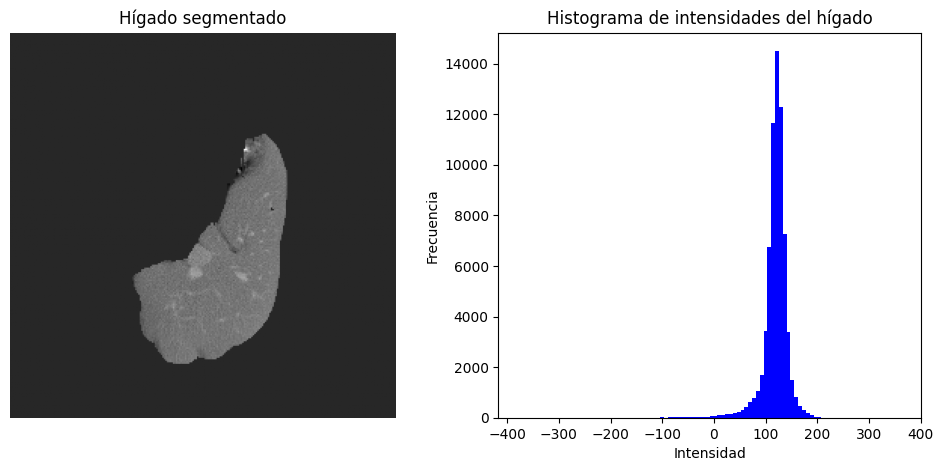

In [200]:
seg_vol= dict_vols["segmentation_0"] #volumen de segmentación binarizado
original_vol= dict_vols["volume_0"] #volumen original
seg_bin =  (seg_vol == 1)
Higado= original_vol * seg_bin #volumen que contendrá solo el higado de la MRI

higado_vals = Higado[Higado != 0] #elimino el fondo

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(Higado[:, :, 32], cmap="gray") #slice 32 que hallamos arriba
plt.title("Hígado segmentado")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(higado_vals.flatten(), bins=100, color="blue")
plt.title("Histograma de intensidades del hígado")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.show()

In [201]:
assert np.max(Higado)<=364, 'Seguramente su segmentación tiene la etiqueta 2'
assert np.isclose(np.sum(Higado!=0),69166,0.01), 'El volumen total del higado es incorrecto, no lo esta tomando todo'
assert np.isclose(np.mean(Higado),3.396,0.1), f'El valor medio del organo es {np.mean(Higado)} y no deberia ser este, quizá esta normalizando o no está tomando todo el organo'

#### Parte 2.2: Ruido
Un punto importante antes de realizar nuestro modelo de segmentación es el estado de las imagenes. Como utilizaremos las intesidades para realizar nuestra segmentación debemos asegurarnos que no tenemos ruido que afecte nuestras intensidades originales. 

En este caso vamos a simular la adicion de ruido a nuestro volumen 0. El ruido adicionado será de tipo gausiano y sal/pimienta. Haga un plot del higado segmentado corrupto (mismo slice) y su respectivo histograma.

In [204]:
salt_peper='' #volumen con ruido de sal y pimienta
gaussian='' #volumen con ruido gaussiano

volume=nib.load(os.path.join('DB','train','volume_0.nii.gz')).get_fdata() #volumen 0

np.random.seed(42)

gaussian=volume + np.random.normal(0, np.std(volume) * 0.1, volume.shape)  #volumen con ruido gaussiano

salt_peper=volume.copy() #volumen con ruido de sal y pimienta
p=0.05 #probabilidad de que un pixel se vea afectado por el ruido
noise_mask = np.random.choice([0, 1, 2], size=salt_peper.shape,p=[1 - p, p/2, p/2]) #0: sin ruido, 1: sal, 2: pimienta
salt_peper[noise_mask == 1] = np.max(volume)  #sal
salt_peper[noise_mask == 2] = np.min(volume)  #pimienta


dict_keys(['segmentation_0', 'segmentation_1', 'segmentation_10', 'segmentation_11', 'segmentation_12', 'segmentation_13', 'segmentation_14', 'segmentation_15', 'segmentation_18', 'segmentation_19', 'segmentation_2', 'segmentation_20', 'segmentation_21', 'segmentation_23', 'segmentation_27', 'segmentation_28', 'segmentation_29', 'segmentation_5', 'segmentation_6', 'segmentation_9', 'volume_0', 'volume_1', 'volume_10', 'volume_11', 'volume_12', 'volume_13', 'volume_14', 'volume_15', 'volume_18', 'volume_19', 'volume_2', 'volume_20', 'volume_21', 'volume_23', 'volume_27', 'volume_28', 'volume_29', 'volume_5', 'volume_6', 'volume_9'])


<function matplotlib.pyplot.show(close=None, block=None)>

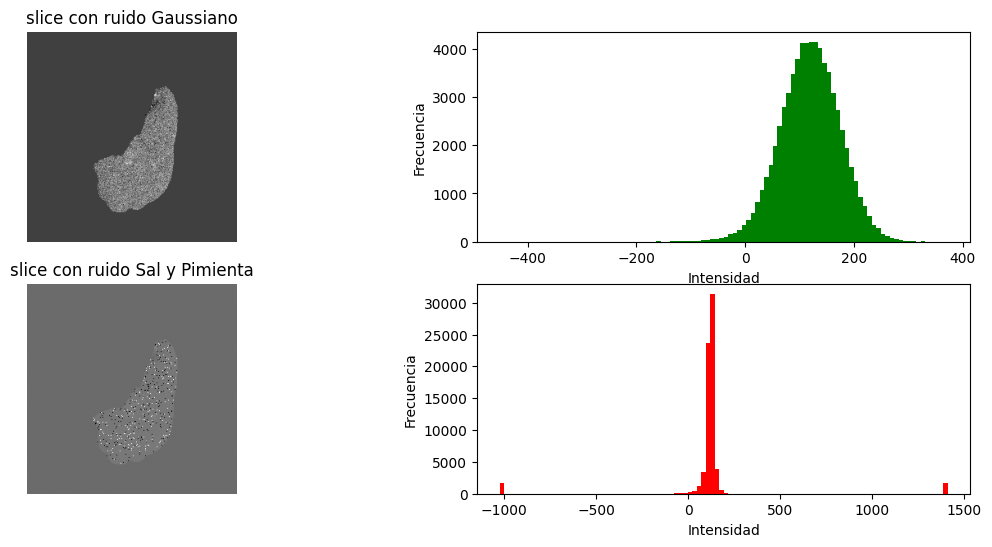

In [205]:
Higado_salt_peper= salt_peper * seg_bin #volumen que contendrá solo el higado de la MRI con ruido sal y pimienta
Higado_gaussian= gaussian * seg_bin #volumen que contendrá solo el higado de la MRI con ruido gaussiano

higado_gaussian_vals = Higado_gaussian[Higado_gaussian != 0]
higado_salt_vals = Higado_salt_peper[Higado_salt_peper != 0]


plt.figure(figsize= (14,6))

#Gaussiano
plt.subplot(2, 2, 1)
plt.imshow(Higado_gaussian[:, :, 32], cmap="gray")
plt.title("slice con ruido Gaussiano")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.hist(higado_gaussian_vals.flatten(), bins=100, color="green")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

#Sal y Pimienta
plt.subplot(2, 2, 3)
plt.imshow(Higado_salt_peper[:, :, 32], cmap="gray")
plt.title("slice con ruido Sal y Pimienta")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.hist(higado_salt_vals.flatten(), bins=100, color="red")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

plt.tight_layout
plt.show

In [78]:
assert np.max(Higado_salt_peper)<=1411, 'Seguramente su segmentación tiene la etiqueta 2'
assert np.isclose(np.sum(Higado_salt_peper!=0),69166,0.01), 'El volumen total del higado es incorrecto, no lo esta tomando todo'
assert np.isclose(np.mean(Higado_salt_peper),3.5053,0.001), f'El valor medio del organo es {np.mean(Higado)} y no deberia ser este, quizá esta normalizando o no está tomando todo el organo'

assert np.max(Higado_gaussian)<=380, 'Seguramente su segmentación tiene la etiqueta 2'
assert np.isclose(np.sum(Higado_gaussian!=0),69166,0.01), 'El volumen total del higado es incorrecto, no lo esta tomando todo'
assert np.isclose(np.mean(Higado_gaussian),3.3918,0.0001), f'El valor medio del organo es {np.mean(Higado)} y no deberia ser este, quizá esta normalizando o no está tomando todo el organo'

### Parte 3: Remoción de ruido
Una parte importante a la hora de resolver problemas de vision por computador es el preprocesamiento. El ruido puede tener diversas fuentes y puede corromper la imagen de diferentes formas. Es nuestro trabajo manipular las imagenes de tal forma que sean más faciles de procesar por nuestro algoritmo de predicción. Es tambien muy importante hacer un diseño exhaustivo del procedimiento de filtrado que realizaremos, ya que no todos los filtros nos ayudaran a el procesamiento de las imagenes. Algunos filtros son muy especializados en el tipo de ruido que logrará filtrar, algunos filtros pueden magnificar el ruido o incluso dañar la imagen.

#### Parte 3.1: Filtrado lineal

Una primera idea puede ser el uso de la cross correlacion para el trabajo del filtrado. Use la función de scipy.signal.correlate y diseñe un filtro medio 3x3. Tambien use la función scipy.ndimage.gaussian_filter para hacer un filtro gaussiano y experimente con el sigma para obtener mejores resultados. Utilice los dos volumenes, extraiga el slice axial encontrado en el punto 1 y use estos filtros, guarde los resultados en variables. Haga un subplot de 4 filas y 3 columnas, en las filas iran los diferentes ruidos con los diferentes filtros (ruido gaussiano con filtro medio, ruido gaussiano con filtro gaussiano, etc.) y en las columnas la imagen original (solo el higado), la imagen procesada y el histograma de la imagen procesada.

> - **Nota:** Procese las imagenes orignales y luego si extraiga unicamente el higado, no lo haga al reves. Use el parametro "same" para mantener el tamaño de la imagen original.

In [238]:
media_filter= np.ones((3, 3, 3))/ 27 #arreglo ndarray del filtro medio

media_salt_peper= correlate(salt_peper, media_filter, mode="same") #slice de ruido sal y pimienta filtrado con filtro medio
gaussian_salt_peper= gaussian_filter(salt_peper, sigma=3) #slice de ruido sal y pimienta filtrado con filtro gaussiano, sigma 3
media_gaussian= correlate(gaussian, media_filter, mode="same") #slice de ruido gaussiano filtrado con filtro medio
gaussian_gaussian= gaussian_filter(gaussian, sigma=3) #slice de ruido gaussiano filtrado con filtro gaussiano, sigma 3

gaussian_salt_peper_higado= gaussian_salt_peper * seg_bin #slice de ruido sal y pimienta filtrado con filtro gaussiano solo del higado
gaussian_gaussian_higado= gaussian_gaussian * seg_bin #slice de ruido gaussiano filtrado con filtro gaussiano solo del higado
media_salt_peper_higado= media_salt_peper * seg_bin #slice de ruido sal y pimienta filtrado con filtro medio solo del higado
media_gaussian_higado = media_gaussian * seg_bin #slice de ruido gaussiano filtrado con filtro medio solo del higado

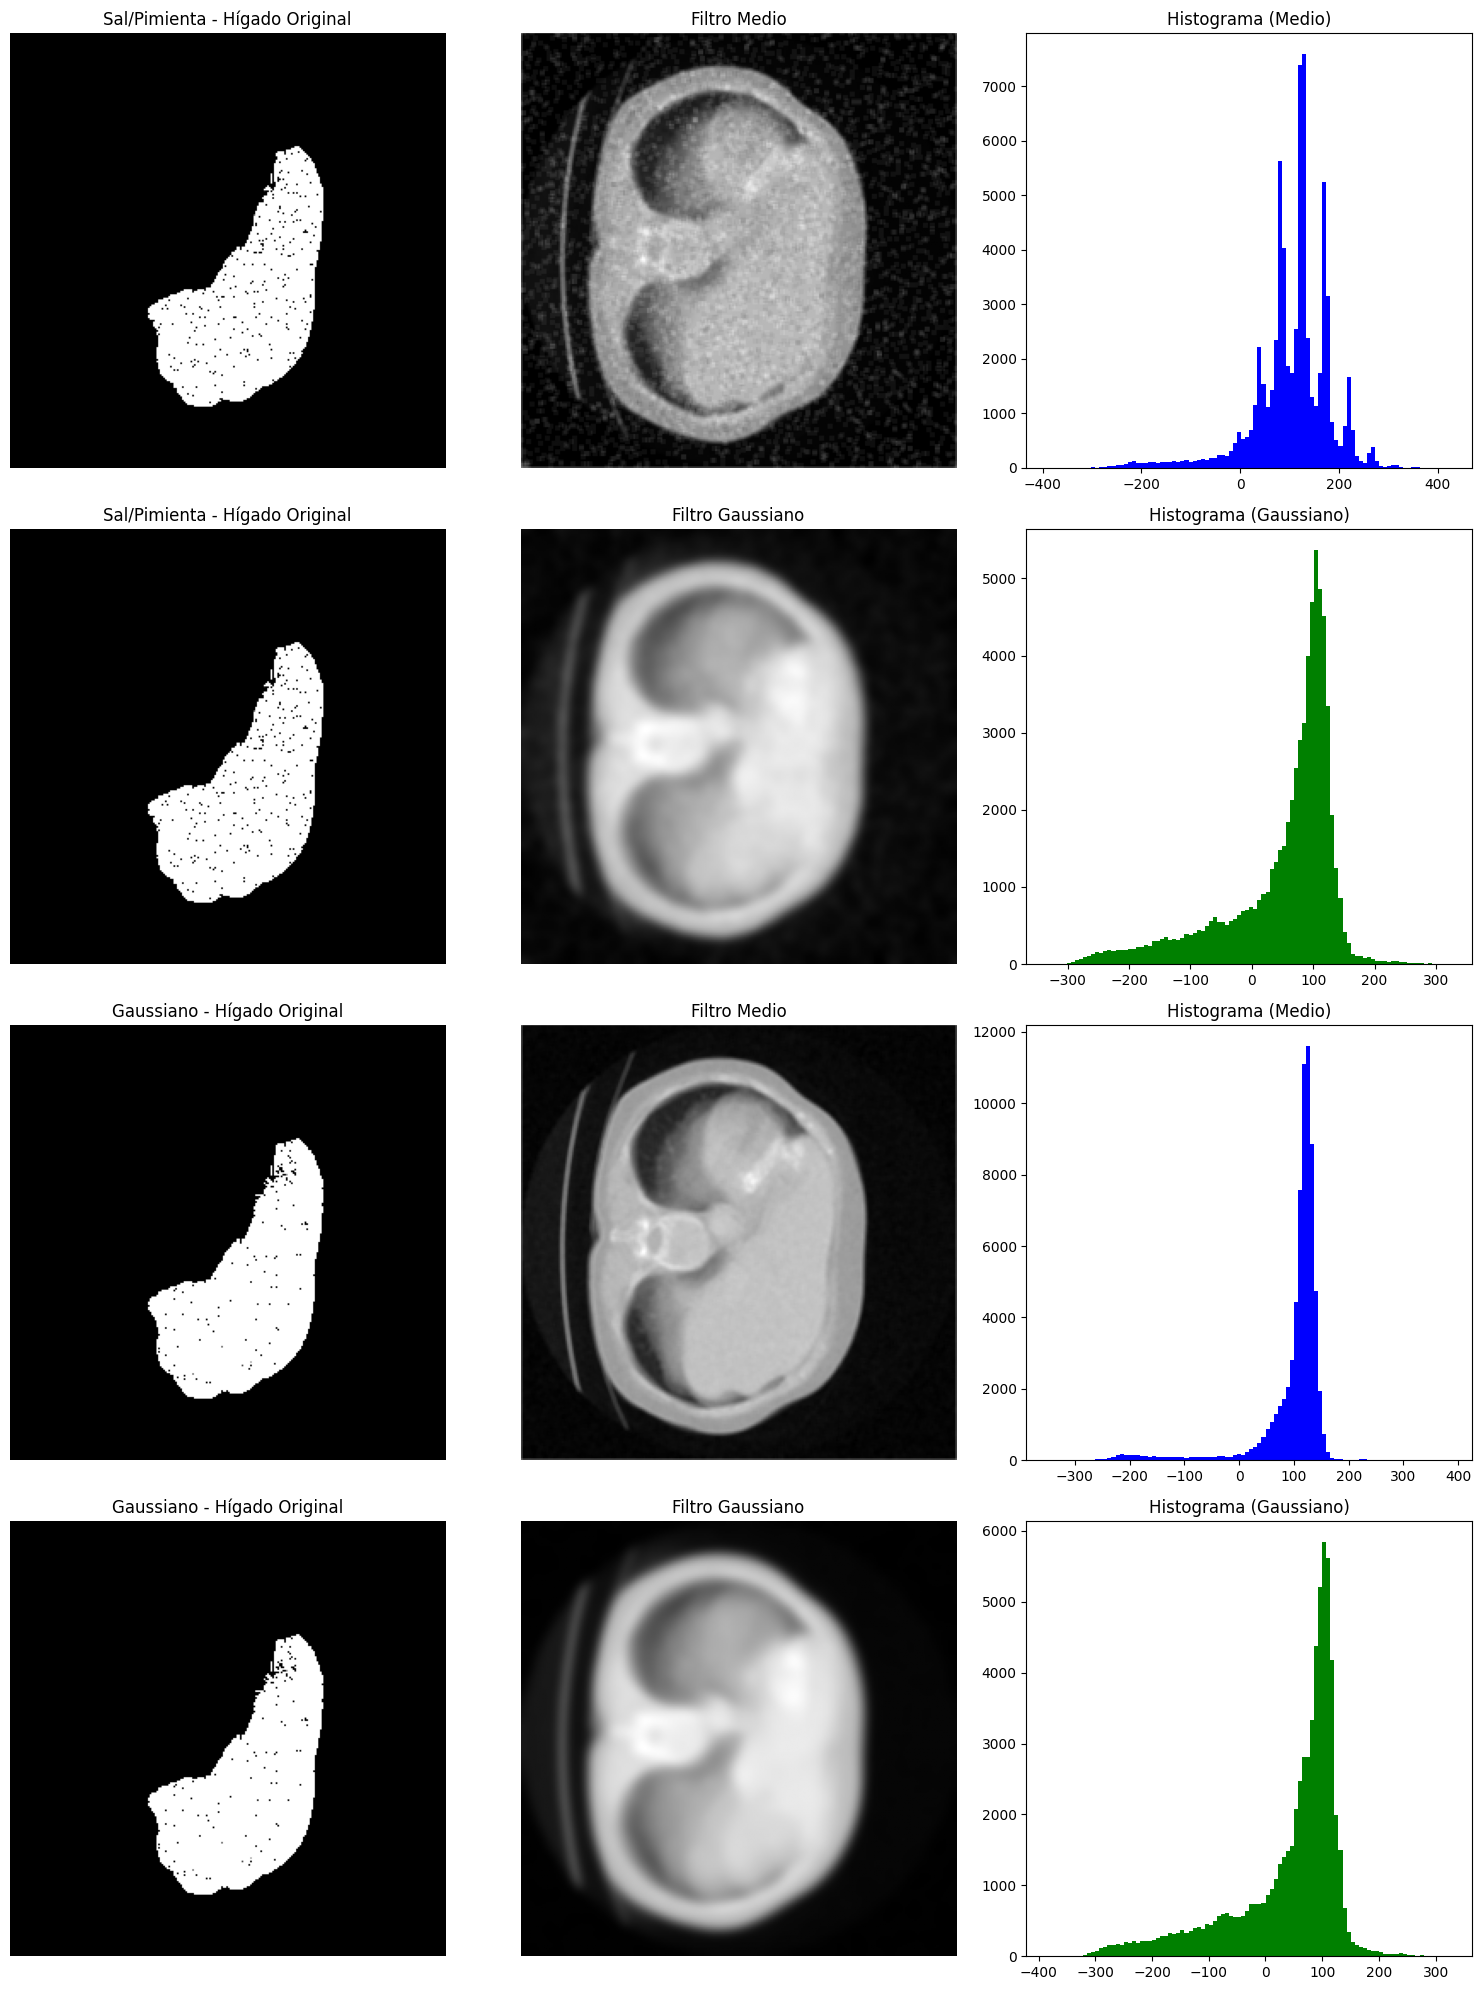

In [377]:
slice = 32
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# --- Fila 1: Ruido sal y pimienta con filtro medio ---
axes[0,0].imshow(salt_peper[:,:,slice] * seg_bin[:,:,slice], cmap='gray', vmin='0', vmax= '1')
axes[0,0].set_title("Sal/Pimienta - Hígado Original")
axes[0,0].axis("off")
axes[0,1].imshow(media_salt_peper[:,:,slice], cmap='gray')
axes[0,1].set_title("Filtro Medio")
axes[0,1].axis("off")
axes[0,2].hist(media_salt_peper_higado[media_salt_peper_higado != 0].flatten(), bins=100, color='blue')
axes[0,2].set_title("Histograma (Medio)")

# --- Fila 2: Ruido sal y pimienta con filtro gaussiano ---
axes[1,0].imshow(salt_peper[:,:,slice] * seg_bin[:,:,slice], cmap='gray', vmin='0', vmax= '1')
axes[1,0].set_title("Sal/Pimienta - Hígado Original")
axes[1,0].axis("off")
axes[1,1].imshow(gaussian_salt_peper[:,:,slice], cmap='gray')
axes[1,1].set_title("Filtro Gaussiano")
axes[1,1].axis("off")
axes[1,2].hist(gaussian_salt_peper_higado[gaussian_salt_peper_higado != 0].flatten(), bins=100, color='green')
axes[1,2].set_title("Histograma (Gaussiano)")

# --- Fila 3: Ruido gaussiano con filtro medio ---
axes[2,0].imshow(gaussian[:,:,slice] * seg_bin[:,:,slice], cmap='gray', vmin='0', vmax= '1')
axes[2,0].set_title("Gaussiano - Hígado Original")
axes[2,0].axis("off")
axes[2,1].imshow(media_gaussian[:,:,slice], cmap='gray')
axes[2,1].set_title("Filtro Medio")
axes[2,1].axis("off")
axes[2,2].hist(media_gaussian_higado[media_gaussian_higado != 0].flatten(), bins=100, color='blue')
axes[2,2].set_title("Histograma (Medio)")

# --- Fila 4: Ruido gaussiano con filtro gaussiano ---
axes[3,0].imshow(gaussian[:,:,slice] * seg_bin[:,:,slice], cmap='gray', vmin='0', vmax= '1')
axes[3,0].set_title("Gaussiano - Hígado Original")
axes[3,0].axis("off")
axes[3,1].imshow(gaussian_gaussian[:,:,slice], cmap='gray')
axes[3,1].set_title("Filtro Gaussiano")
axes[3,1].axis("off")
axes[3,2].hist(gaussian_gaussian_higado[gaussian_gaussian_higado != 0].flatten(), bins=100, color='green')
axes[3,2].set_title("Histograma (Gaussiano)")

plt.tight_layout()
plt.show()

In [220]:
assert np.isclose(np.sum(media_filter), 1), 'La suma de todos los elementos del filtro deben sumar 1'
assert np.sum(media_filter==1/(3*3*3))==27, 'Su filtro medio esta mal construido'
x,y,z=gaussian_salt_peper_higado.shape

#### Parte 3.2: Filtrado no lineal
El filtrado lineal nos es muy util para obtener caracteristicas visuales de las imagenes y tambien para reducir cierto tipo de ruido. Sin embargo, pudieron observar cualitativamente las limitaciones de este tipo de filtrado. Una idea interesante puede ser el uso de filtrado no lineal para la eliminación de ruido y menor destrucción de la imagen original. Use los filtros maximo, minimo, mediano y mediano adaptativo para remover el ruido de las imagenes del anterior punto (puede usar la implementación del tutorial) haga una función que pueda hacer todos estos filtros segun se indique por parametro, tome en cuenta la condición de frontera como 0s. Haga un subplot de 2 filas 5 columnas, donde las filas son los diferentes ruidos y las columnas son la imagen original y los 4 tipos de filtros.

In [ ]:
def stage_a(Z_min, Z_med, Z_max, Z_xy, S_xy, S_max):
    # Se identifica si la mediana es mínimo o máximo también
    if Z_min < Z_med < Z_max:
        return stage_b(Z_min, Z_med, Z_max, Z_xy)
    else:
        S_xy += 2
        # Se identifica si se alcanzó el tamaño máximo de ventana
        if(S_xy <= S_max):
            return stage_a(Z_min, Z_med, Z_max, Z_xy, S_xy, S_max)
        else:
            return Z_med

def stage_b(Z_min, Z_med, Z_max, Z_xy):
    # Se identifica si la intensidad del píxel central es mínima o máxima
    if Z_min < Z_xy < Z_max:
        return Z_xy
    else:
        return Z_med

def adaptative_median_filter_3D(volume, S_0, S_max):
    a = (S_max - 1)//2
    volume_aux = np.zeros((volume.shape[0]+2*a, volume.shape[1]+2*a, volume.shape[2]+2*a))
    volume_aux[a:volume.shape[0]+a, a:volume.shape[1]+a, a:volume.shape[2]+a] = volume
    output_volume = volume_aux.copy()
    
    # Para cada voxel en el que se pueda centrar una ventana de tamaño máximo:
    for i in range(a, volume_aux.shape[0] - a):
        for j in range(a, volume_aux.shape[1] - a):
            for k in range(a, volume_aux.shape[2] - a):
                S_xy = S_0
                window = volume_aux[i - a : i + a + 1, 
                                   j - a : j + a + 1, 
                                   k - a : k + a + 1]
                ordered_vector = np.sort(window.flatten())
                # Se elige el mínimo, el máximo y la mediana de dicho vector
                Z_min = ordered_vector[0]
                Z_max = ordered_vector[-1]
                Z_med = ordered_vector[len(ordered_vector) // 2]
                Z_xy = volume_aux[i, j, k]
                # Se ejecuta la etapa A
                output_volume[i, j, k] = stage_a(Z_min, Z_med, Z_max, Z_xy, S_xy, S_max)
    
    # Se retorna el volumen de salida
    return output_volume[a:volume.shape[0]+a, a:volume.shape[1]+a, a:volume.shape[2]+a]

def No_linear_filter(Im, filter_type, window, max_window=3):
    if window % 2 == 0:
        window += 1  # Asegurar que la ventana sea impar
    if filter_type == 'min':
        return minimum_filter(Im, size=window)
    elif filter_type == 'max':
        return maximum_filter(Im, size=window)
    elif filter_type == 'median':
        return median_filter(Im, size=window)
    elif filter_type == 'median_adapt':
        return adaptative_median_filter_3D(Im, window, max_window)

In [355]:
Max_salt_peper = No_linear_filter(salt_peper, 'min', 3)
Min_salt_peper = No_linear_filter(salt_peper, 'max', 3)
Median_salt_peper = No_linear_filter(salt_peper, 'median', 3)
MedianAdapt_salt_peper = No_linear_filter(salt_peper, 'median_adapt', 3, 7)

Max_gaussian = No_linear_filter(gaussian, 'min', 3)
Min_gaussian = No_linear_filter(gaussian, 'max', 3)
Median_gaussian = No_linear_filter(gaussian, 'median', 3)
MedianAdapt_gaussian = No_linear_filter(gaussian, 'median_adapt', 3, 7)

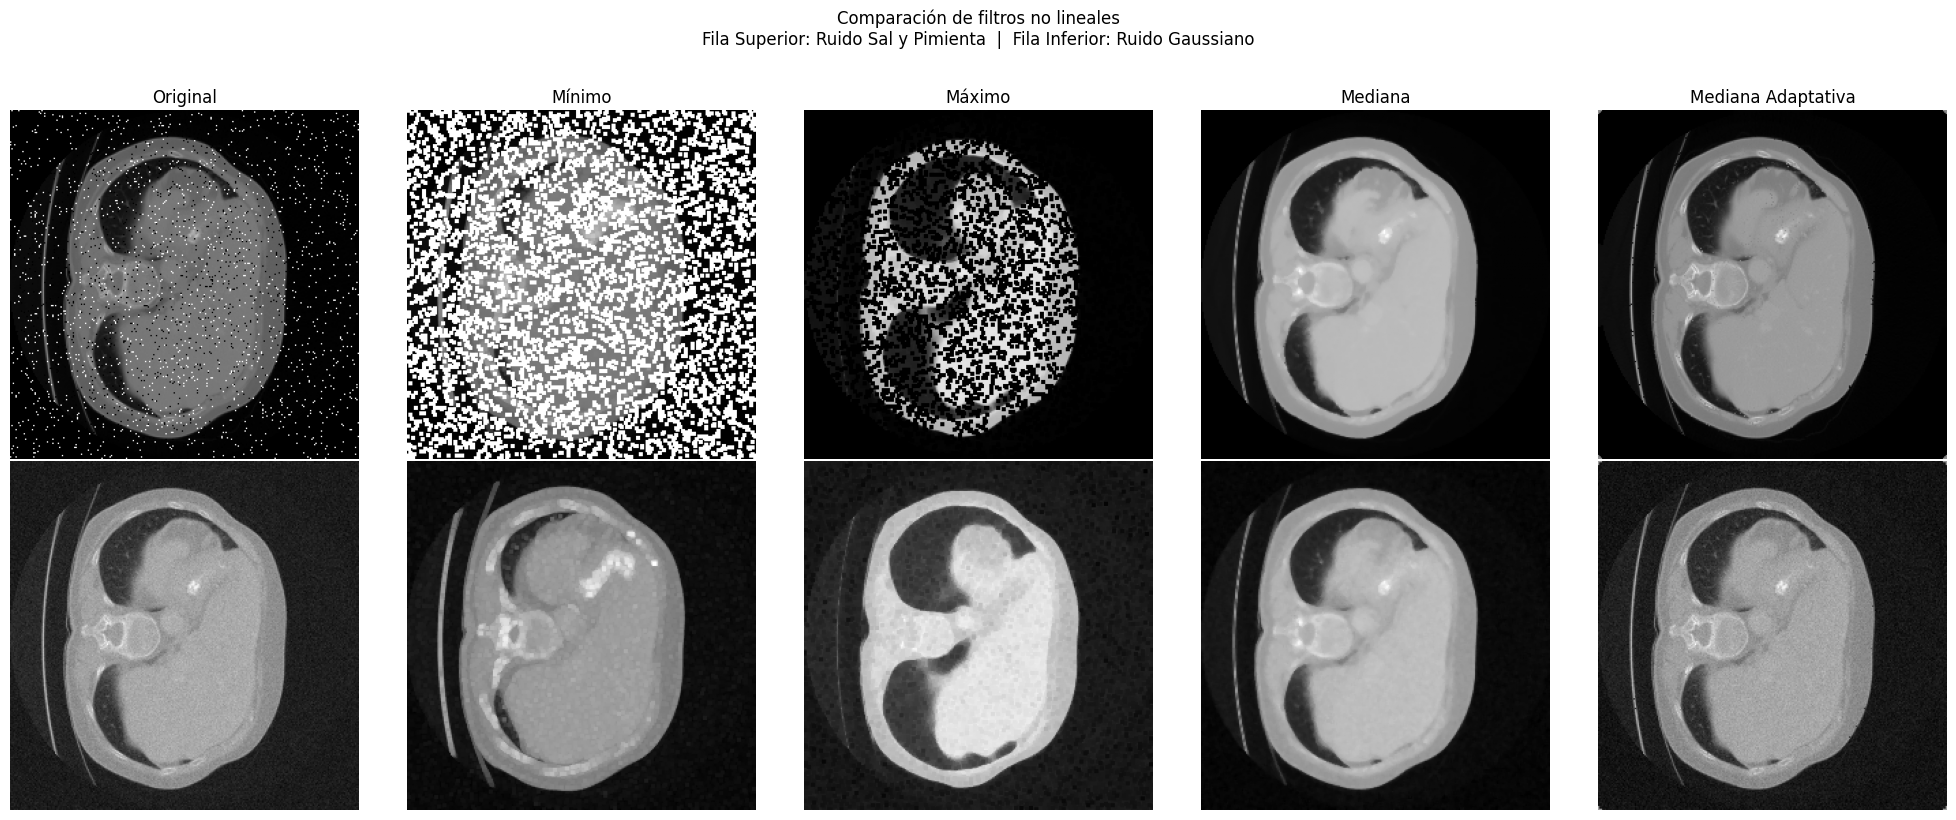

In [380]:
# Configurar figura
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Fila 1: Ruido Sal y Pimienta
axs[0,0].imshow(salt_peper[:,:,32] , cmap='gray')
axs[0,1].imshow(Min_salt_peper[:,:,32], cmap='gray')
axs[0,2].imshow(Max_salt_peper[:,:,32], cmap='gray')
axs[0,3].imshow(Median_salt_peper[:,:,32], cmap='gray')
axs[0,4].imshow(MedianAdapt_salt_peper[:,:,32], cmap='gray')

# Fila 2: Ruido Gaussiano
axs[1,0].imshow(gaussian[:,:,32] , cmap='gray')
axs[1,1].imshow(Min_gaussian[:,:,32], cmap='gray')
axs[1,2].imshow(Max_gaussian[:,:,32], cmap='gray')
axs[1,3].imshow(Median_gaussian[:,:,32], cmap='gray')
axs[1,4].imshow(MedianAdapt_gaussian[:,:,32], cmap='gray')

# Configurar títulos y formato
for row in range(2):
    for col in range(5):
        axs[row,col].set_title(titles[col] if row == 0 else '')
        axs[row,col].axis('off')

plt.suptitle('Comparación de filtros no lineales\nFila Superior: Ruido Sal y Pimienta  |  Fila Inferior: Ruido Gaussiano', y=1.02)
plt.tight_layout()
plt.show()

#### Parte 3.3 Evaluación cuantitativa

Hemos podido experimentar con los diferentes filtros que tenemos a nuestra disposición obteniendo resultados mejores o peores. La comparación que hemos podido tener es meramente cualitativa, sin embargo, contamos con una herramienta que nos permite saber que tan eficaz ha sido nuestro filtrado, el PSNR. Cree una función que entre como parametro 2 imagenes de un solo canal y retorne su PSNR. Considere el maximo de la imagen como 1.

In [350]:
def PSNR(Im,Filtered):
    '''
    :param Im: Imagen oringinal.
    :param Filtered: Imagen filtrada.
    '''
    mse = np.mean((Im - Filtered) ** 2)
    max_val = 1.0
    result = 10 * np.log10((max_val ** 2) / mse)

    return round(result, 2)


In [334]:
print(original_vol.shape)

(256, 256, 37)


In [356]:
Value_salt_peper_media=PSNR(original_vol,media_salt_peper)
Value_salt_peper_gaussian=PSNR(original_vol,gaussian_salt_peper)
Value_salt_peper_max=PSNR(original_vol,Max_salt_peper)
Value_salt_peper_min=PSNR(original_vol,Min_salt_peper)
Value_salt_peper_median=PSNR(original_vol,Median_salt_peper)
Value_salt_peper_medianAdapt=PSNR(original_vol,MedianAdapt_salt_peper)

Value_gaussian_media=PSNR(original_vol,media_gaussian)
Value_gaussian_gaussian=PSNR(original_vol,gaussian_gaussian)
Value_gaussian_max=PSNR(original_vol,Max_gaussian)
Value_gaussian_min=PSNR(original_vol,Min_gaussian)
Value_gaussian_median=PSNR(original_vol,Median_gaussian)
Value_gaussian_medianAdapt=PSNR(original_vol,MedianAdapt_gaussian)

In [358]:
arreglo=np.arange(0,27).reshape((3,3,3))
assert np.isclose(PSNR(arreglo,arreglo[::-1]),-23.34,0.1), f'Su función de PSNR no funciona como debería, el PSNR de esta muestra debería ser -23.34 y es {PSNR(arreglo,arreglo[::-1])}'
assert Value_salt_peper_median>Value_salt_peper_media, 'El filtro mediano en sal y pimienta no es el mejor filtro'
assert Value_gaussian_median>Value_gaussian_max, 'El filtro mediano en ruido gaussiano no es el mejor filtro'
assert Value_gaussian_median>Value_gaussian_medianAdapt, 'El filtro mediano en ruido gaussiano no es el mejor filtro'

assert np.isclose(Value_salt_peper_media,-42.4,0.01), 'Filtro mal su volumen de sal y pimienta con el filtro medio'
assert np.isclose(Value_salt_peper_gaussian,-42.58,0.01), 'Filtro mal su volumen de sal y pimienta con el filtro gaussiano'
assert np.isclose(Value_salt_peper_max,-54.16,0.01), 'Filtro mal su volumen de sal y pimienta con el filtro maximo'
assert np.isclose(Value_salt_peper_median,-34.83,0.01), 'Filtro mal su volumen de sal y pimienta con el filtro mediano'
assert np.isclose(Value_gaussian_median,-34.97,0.01), 'Filtro mal su volumen gaussiano con el filtro mediano'
assert np.isclose(Value_salt_peper_medianAdapt,-37.99,0.01), 'Filtro mal su volumen sal y pimienta con el filtro mediano adaptativo'

### Parte 4: Segmentación
Ahora, determinaremos cual será nuestro baseline este miniproyecto para segmentar el higado. Lo primero que debemos determinar será nuestra metodología de evaluación.

#### Parte 4.1: Jaccard 3D
Nuestra segmentación no es una imagen binaria, recuerde que estamos tratando con volumenes. En esta ocasión tendremos un volumen de segmentación. El cambio de output y de groundtruth requiere un cambio de métrica de evaluación, ya no podemos usar un Jaccard en 2D como siempre hemos hecho, tampoco podemos hacer un promedio de Jaccards en 2D. Implemente una función de Jaccard 3D que ingrese como parametro el volumen de predicción y el volumen de groundtruth y retorne el indice de Jaccard.

> **Recuerde:** La segmentación de groundtruth tiene 3 diferentes labels, usted quiere una segmentación binaria. Considere el label 1 y 2 como uno mismo.

Cree una función que retorne la precisión, la cobertura y la F-medida dado un volumen de predicción y uno de anotación. Tenga en cuenta los problemas con la división entre 0 (tome epsilon como 1x10^-6)

In [360]:
def Jaccard_3D(Im,Gt):
    '''
    :param Im: Volumen de prediccion.
    :param Gt: Segmentacion groundtruth.
    '''
    Im_mask = np.zeros_like(Im)
    Im_mask[Im > 0] = 1
    #Se hace lo mismo para Gt
    Gt_mask = np.zeros_like(Gt)
    Gt_mask[Gt > 0] = 1

    # Se calcula la intersección
    interseccion = np.sum(np.logical_and(Im_mask, Gt_mask))
    # Se calcula la unión
    union = np.sum(np.logical_or(Im_mask, Gt_mask))
    J = interseccion/union
    return J

def P_C_F_3D(Im,Gt):
    '''
    :param Im: Volumen de prediccion.
    :param Gt: Segmentacion groundtruth.
    '''
    Im_mask = np.zeros_like(Im)
    Im_mask[Im > 0] = 1
    # Se hace lo mismo para el Gt
    Gt_mask = np.zeros_like(Gt)
    Gt_mask[Gt > 0] = 1

    # Verdaderos positivos
    TP = np.sum(Im_mask * Gt_mask)
    #Falsos positivos y falsos negativos
    FP = np.sum(Im_mask) - TP
    FN = np.sum(Gt_mask) - TP

    epsilon = 1e-6
    Precision = TP / (TP + FP + epsilon)
    Cobertura = TP / (TP + FN + epsilon)
    #Se calcula la F-medida
    Fscore = 2 * Precision * Cobertura / (Precision + Cobertura + epsilon)
    return Precision,Cobertura,Fscore

In [361]:
assert np.isclose(Jaccard_3D(original_vol>100,seg_vol),0.305,0.01), 'El Jaccard 3D no da los resultados que debe, recuerde que no es lo mismo que un Jaccard 2D promediado'
P,C,F=P_C_F_3D(original_vol>100,seg_vol)
assert P<C, 'La precisión debe ser menor que la cobertura'
assert F<C and F>P, 'La F medida debe ser menor que la cobertura y mayor que la precisión'
assert np.isclose(F,0.47,0.01), 'La F medida esta mal calculada'

#### Parte 4.2: Elemento conexo
La metodología que utilizaremos para segmentar se basará en las intensidades, sin embargo, muchos tejidos tienen intensidades similares a nuestro organo de interes, lo que resulta en muchos falsos positivos. La idea será umbralizar nuestro volumen, posteriormente nos quedaremos con el componente conexo más grande. 

La función vol_max_component será una función a la que entraran 3 parámetros. El volumen a segmentar, un valor máximo y un valor mínimo. Lo primero a realizar es umbralizar el volumen utilizando el valor máximo, es decir, que todos los voxeles que tengan una intensidad menor a ese valor serán 1 y todas las demás serán 0. Luego, se umbralizará el volumen utilizando el valor mínimo, es decir, que todos los voxeles que tengan una intensidad mayor a ese valor serán 1 y todas las demás serán 0. Posteriormente, calcularemos la intersección entre esos dos volúmenes. Finalmente, hallaremos el elemento conexo más grande de la intersección previamente calculada.

> - Para determinar el mayor elemento conexo, use skimage.measure.label. Esta función le dará una label a cada elemento conexo, es decir que cambiará su intensidad por un numero de 1 a N siendo N la cantidad de elementos conexos. Puede usar np.sum junto con algun operador logico para determinar el area de cada elemento conexo. La mayor label no necesariamente es el mayor elemento conexo. El fondo es el mayor elemento conexo, no lo tenga en cuenta!

In [367]:
def vol_max_component(volume, max=1, min=0):
    """Esta función realiza la segmentación mediante elemento conexo más grande en 3D

    Args:
        volume (np.ndarray): Volumen a segmentar
        max (float | None): Limite inferior para realizar la segmentación
        min (float | None): Limite superior para realiza la segmentación

    Return:
        (np.ndarray): Volumen segmentado
    """
    if max is not None:
        vol_max = (volume < max)
    else:
        vol_max = np.ones_like(volume, dtype=np.uint8)

    # Umbralización inferior
    if min is not None:
        vol_min = (volume > min)
    else:
        vol_min = np.ones_like(volume, dtype=np.uint8)

    intersect_vol = vol_max & vol_min
    labeled_vol = label(intersect_vol)

    if labeled_vol.max() == 0:  # No hay elementos
        return np.zeros_like(volume, dtype=np.uint8)

    # Calcular tamaño de cada elemento conexo
    counts = np.array([np.sum(labeled_vol == i) for i in range(1, labeled_vol.max() + 1)])
    largest_label = np.argmax(counts) + 1

    # Crear volumen segmentado final
    segment_vol = (labeled_vol == largest_label)
    return segment_vol

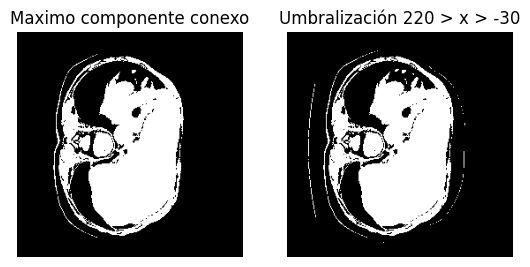

In [368]:
higado_umbral=(original_vol>-30) & (original_vol<220)
higado_seg=vol_max_component(original_vol,220,-30)
               
fig,ax=plt.subplots(1,2)
ax[1].imshow(higado_umbral[..., 32], cmap = 'gray')
ax[1].axis('off')
ax[0].set_title('Maximo componente conexo')
ax[0].imshow(higado_seg[..., 32], cmap = 'gray')
ax[0].axis('off')
ax[1].set_title('Umbralización 220 > x > -30')
plt.show()

assert np.sum((1-higado_umbral)*higado_seg)==0, 'Usted segmentó el fondo'
assert np.isclose(np.sum(higado_seg),574552,0.01), 'El elemento conexo segmentado no es el maximo'

Utilizando esta metodología de segmentación, encuentre el mejor umbral para obtener la mejor segmentación posible. Pongalo en su reporte junto con algunos ejemplos buenos y malos de su implementación. Busque las partes donde el higado se segmenta bien y partes donde no se segmenta el higado.

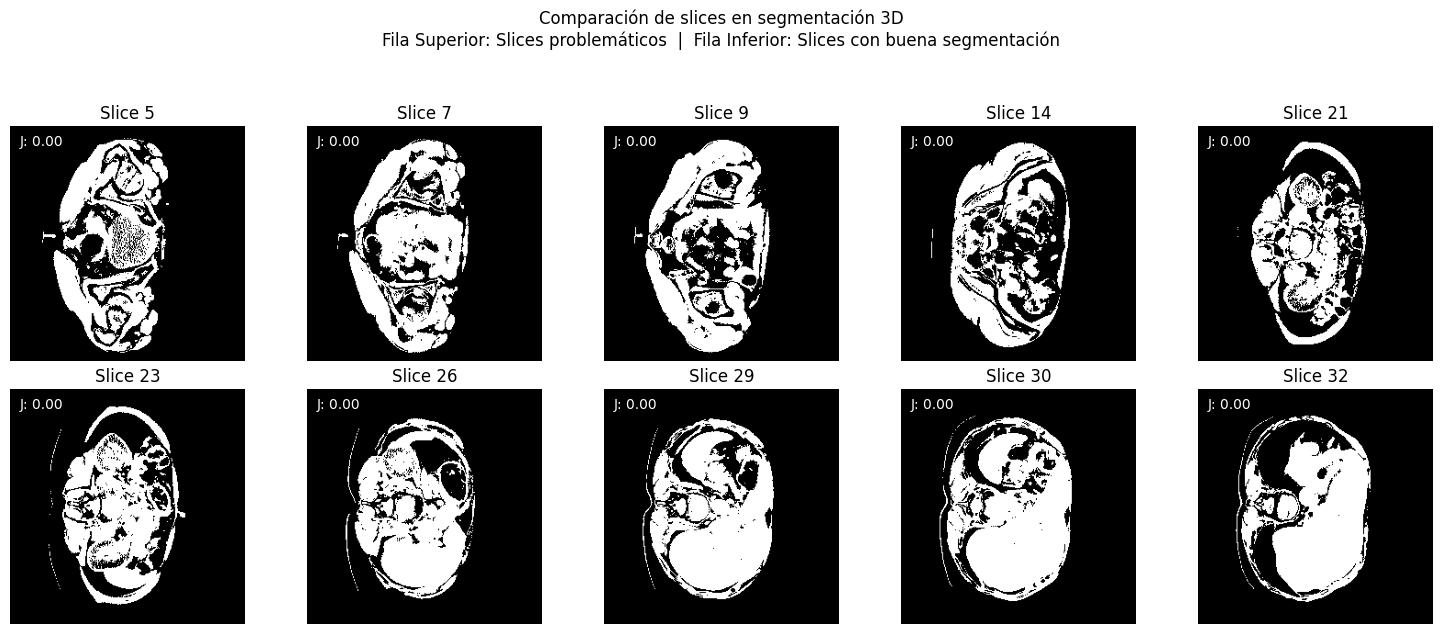

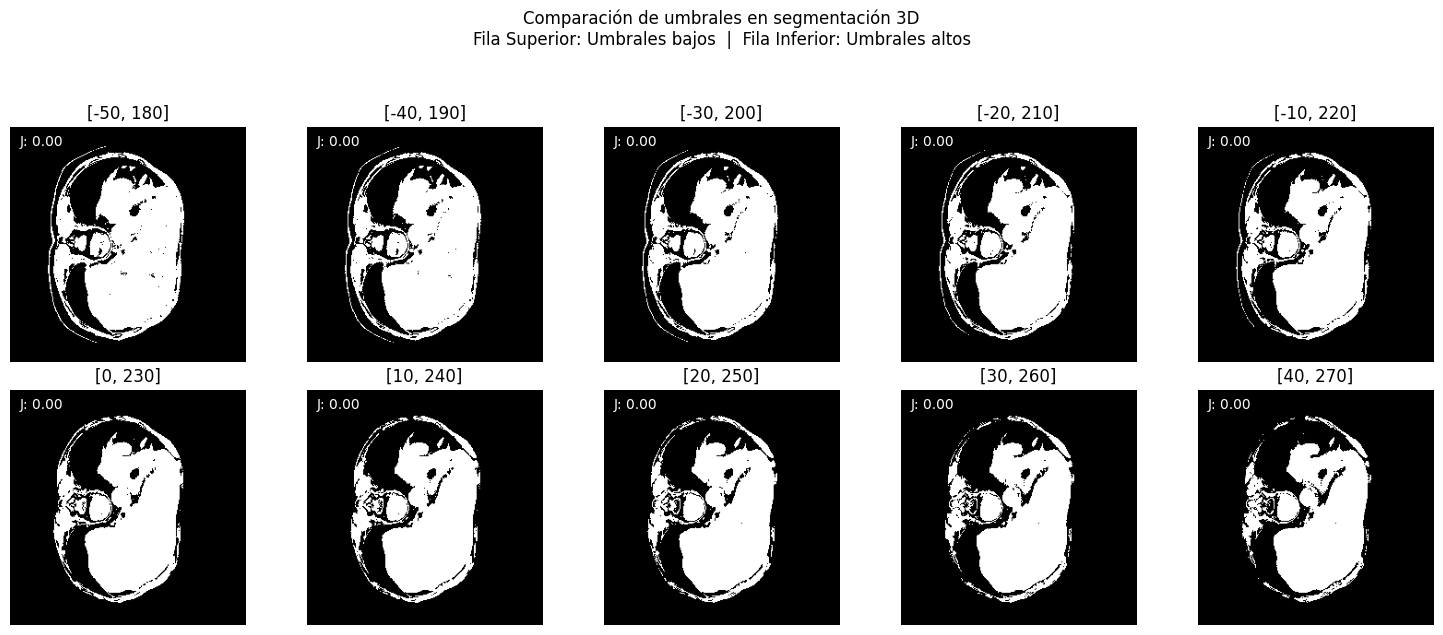

In [391]:
# Definir slices para comparación - slices donde la segmentación varía
valores = [5, 7, 9, 14, 21, 23, 26, 29, 30, 32]  # Slices experimentales

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
plt.suptitle('Comparación de slices en segmentación 3D\nFila Superior: Slices problemáticos  |  Fila Inferior: Slices con buena segmentación', y=1.05)

contador = -1
for x in range(2):
    for y in range(5):
        contador += 1
        slice_idx = valores[contador]
        
        # Mostrar la segmentación 3D en el slice correspondiente
        ax[x, y].imshow(mejor_seg[:, :, slice_idx], cmap='gray')
        ax[x, y].axis('off')
        ax[x, y].set_title(f'Slice {slice_idx}')
        
        # Calcular y mostrar métrica de calidad para este slice
        jaccard_slice = Jaccard_3D(mejor_seg[:, :, slice_idx:(slice_idx+1)], 
                                  seg_vol[:, :, slice_idx:(slice_idx+1)])
        ax[x, y].text(10, 20, f'J: {jaccard_slice:.2f}', color='white', 
                     bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

# Comparación de diferentes umbrales usando la metodología 3D completa
umbrales_min = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40]  # Umbrales mínimos experimentales
umbrales_max = [180, 190, 200, 210, 220, 230, 240, 250, 260, 270]  # Umbrales máximos experimentales

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
plt.suptitle('Comparación de umbrales en segmentación 3D\nFila Superior: Umbrales bajos  |  Fila Inferior: Umbrales altos', y=1.05)

contador = -1
slice_visualizacion = 32  # Slice fijo para visualizar diferentes umbrales

for x in range(2):
    for y in range(5):
        contador += 1
        umbral_min = umbrales_min[contador]
        umbral_max = umbrales_max[contador]
        
        # Aplicar segmentación 3D completa con los umbrales actuales
        seg_actual = vol_max_component(original_vol, umbral_max, umbral_min)
        
        ax[x, y].imshow(seg_actual[:, :, slice_visualizacion], cmap='gray')
        ax[x, y].axis('off')
        ax[x, y].set_title(f'[{umbral_min}, {umbral_max}]')
        
        # Calcular y mostrar métrica de calidad
        jaccard_total = Jaccard_3D(seg_actual, seg_vol)
        ax[x, y].text(10, 20, f'J: {jaccard_total:.2f}', color='white', 
                     bbox=dict(facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()


## Entregables
Los entregables para esta entrega son un Jupyter notebook (.ipynb), un informe (.pdf) y un archivo de texto (.txt).

El Jupyter notebook debe estar completamente resuelto. Recuerde que la nota depende del funcionamiento de su código. El archivo de texto corresponde a las secciones de código de su Jupyter notebook.

En este miniproyecto debe hacer un informe con Introducción, Resultados y análisis, y Conclusiones respondiendo las preguntas en las secciones donde usted crea pertinente responderlas. Toda la información sobre secciones, preguntas y elementos adicionales está en la siguiente sección de informe. El informe debe utilizar el formato que puede encontrar siguiente [enlace](https://github.com/cvpr-org/author-kit). Si tiene dudas de cómo utilizar el formato puede preguntar al Asistente Graduado.

## Informe:
En esta ocasión, no responderemos unicamente las preguntas sino que comenzaremos a familiarizarnos con la estructura de un informe de visión por computador. En este miniproyecto debe hacer un informe con Introducción, Resultados y análisis, y Conclusiones respondiendo las preguntas en las secciones donde usted crea pertinente responderlas. La extensión máxima del informe es 4 páginas.

### Exploración de base de datos:
* ¿Este problema de segmentación es desbalanceado? Dado nuestro último método con elemento conexo más grande,¿Qué el problema esté desbalanceado puede afectar el desempeño?
* Teniendo en cuenta la cantidad de datos ¿Cree usted que un analisis pixel a pixel es eficiente para realizar una segmentación de todos nuestros datos? **Nota**: Tenga en cuenta que para las entregas posteriores el número de volúmenes será mayor.

### Anotación
* Describa lo que puede observar en los histogramas y volúmenes con ruido, filtrados y originales.
* Teniendo en cuenta los histogramas ¿Qué umbral sería adeacuado para realizar la umbralización?

### Remoción de ruido:
* ¿Que tipo de ruido es más comun en las imagenes medicas?
* ¿Cuales filtros dañaron más su imagen? ¿Por que sucede esto?

### Segmentación:
* ¿Porque la metrica de Jaccard 3D no es igual que la de Jaccard 2D promediado? De una explicación matemática.
* Teniendo en cuenta las metricas de Jaccard 3D, precisión y cobertura responda ¿Porque es necesario establecer una métrica de evaluación acorde a nuestro probelma principal? ¿Son todas estas métricas compatibles? ¿La precisión o la cobertura por si solas serían adecuadas para evaluar el problema? Conteste esta pregunta teniendo en cuenta el desbalance de datos.
* ¿Que organos o estructuras del cuerpo son problematicas para nuestra metodología de segmentación? Grafiquelas.

In [392]:
from utils import *
converter("Entrega 1")